# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import time
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
X_train = pd.read_csv('/content/X_train.txt', delim_whitespace=True, header=None)
X_test = pd.read_csv('/content/X_test.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('/content/y_train.txt', header=None)
y_test = pd.read_csv('/content/y_test.txt', header=None)

<ipython-input-2-e07742e0b036>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('/content/X_train.txt', delim_whitespace=True, header=None)
<ipython-input-2-e07742e0b036>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('/content/X_test.txt', delim_whitespace=True, header=None)


In [3]:
# Divisão: 75% treino, 25% validação
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

### 2. Calcule os ```ccp_alphas```.

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

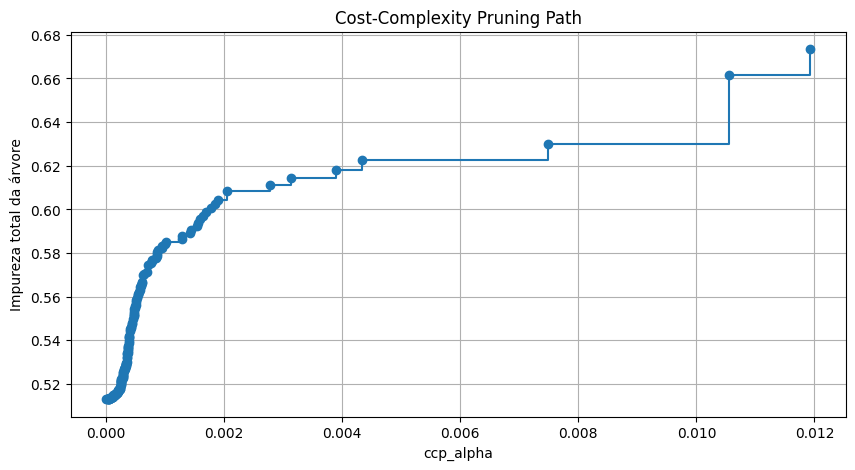

CPU times: user 184 ms, sys: 1.7 ms, total: 186 ms
Wall time: 185 ms


In [5]:
%%time

# Selecione as 3 melhores variáveis
# Substitua pelos índices reais se forem diferentes
colunas_melhores = [0, 10, 20]

X_train_3 = X_train_final.iloc[:, colunas_melhores]
y_train_3 = y_train_final.values.ravel()

# Crie um modelo de árvore com min_samples_leaf=20
clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=20)

# Calcule os valores de ccp_alphas com o método cost_complexity_pruning_path
path = clf.cost_complexity_pruning_path(X_train_3, y_train_3)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Visualize os alphas encontrados
plt.figure(figsize=(10, 5))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Impureza total da árvore")
plt.title("Cost-Complexity Pruning Path")
plt.grid(True)
plt.show()


### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [8]:
%%time

# Use as 3 melhores variáveis
X_train_3 = X_train_final.iloc[:, colunas_melhores]
y_train_3 = y_train_final.values.ravel()

# Calcular os valores de ccp_alpha novamente
clf_temp = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
path = clf_temp.cost_complexity_pruning_path(X_train_3, y_train_3)
ccp_alphas = path.ccp_alphas

# Para limitar o tempo, vamos pegar 1 a cada 10 valores
ccp_alpha_grid = ccp_alphas[::10]

# Define o classificador base
clf = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)

# Define o grid de parâmetros
param_grid = {'ccp_alpha': ccp_alpha_grid}

# Define o cross-validation com 10 folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Medir o tempo
start = time.time()

# Rodar o GridSearchCV
grid_search = GridSearchCV(estimator=clf,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(X_train_3, y_train_3)

end = time.time()
print(f"Tempo total: {end - start:.2f} segundos")

# Melhor alpha e melhor score
print(f"Melhor ccp_alpha: {grid_search.best_params_['ccp_alpha']}")
print(f"Acurácia média (10-fold): {grid_search.best_score_:.2%}")


Tempo total: 6.30 segundos
Melhor ccp_alpha: 0.0008613822875841522
Acurácia média (10-fold): 48.68%
CPU times: user 262 ms, sys: 23 ms, total: 285 ms
Wall time: 6.33 s


### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

Acurácia na base de teste: 47.57%


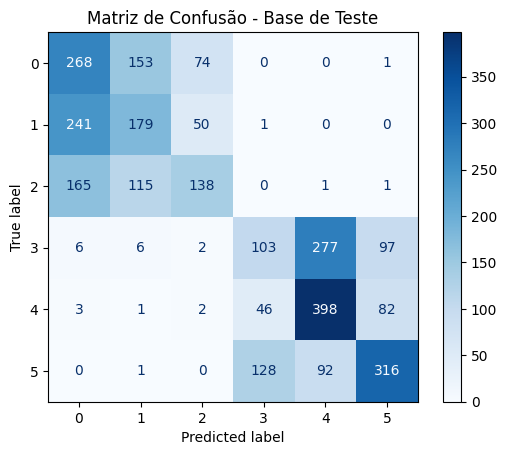

In [11]:
# As 3 melhores variáveis
X_train_full = X_train.iloc[:, colunas_melhores]
X_test_3 = X_test.iloc[:, colunas_melhores]
y_train_full = y_train.values.ravel()
y_test_ = y_test.values.ravel()

# Melhor alpha do Grid Search
melhor_alpha = grid_search.best_params_['ccp_alpha']

# Treinar a árvore final com melhor ccp_alpha
final_tree = DecisionTreeClassifier(min_samples_leaf=20,
                                     ccp_alpha=melhor_alpha,
                                     random_state=42)

final_tree.fit(X_train_full, y_train_full)

# Fazer previsões na base de teste
y_pred_test = final_tree.predict(X_test_3)

# Calcular acurácia
acc_test = accuracy_score(y_test_, y_pred_test)
print(f"Acurácia na base de teste: {acc_test:.2%}")

# Matriz de confusão
cm = confusion_matrix(y_test_, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Base de Teste")
plt.show()


### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [12]:
# Criação da variável binária para a classe com maior erro (classe 0, por exemplo)
classe_dificil = 0
y_train_binaria = (y_train[0] == classe_dificil).astype(int)

# Treinamento de uma árvore simples para essa variável binária
modelo_binario = DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=42)
modelo_binario.fit(X_train, y_train_binaria)

# Verificando a importância das variáveis
importancias = modelo_binario.feature_importances_
top3_idx = importancias.argsort()[-3:][::-1]
print("Top 3 variáveis mais importantes:", top3_idx)

Top 3 variáveis mais importantes: [ 0 16 17]


In [13]:
# Usar essas 3 variáveis para rodar novamente o modelo principal
X_train_sel = X_train.iloc[:, top3_idx]
X_test_sel = X_test.iloc[:, top3_idx]

modelo_melhorado = DecisionTreeClassifier(random_state=42)
modelo_melhorado.fit(X_train_sel, y_train)

DecisionTreeClassifier(random_state=42)

Acurácia na base de teste com as 3 variáveis mais importantes: 53.68%


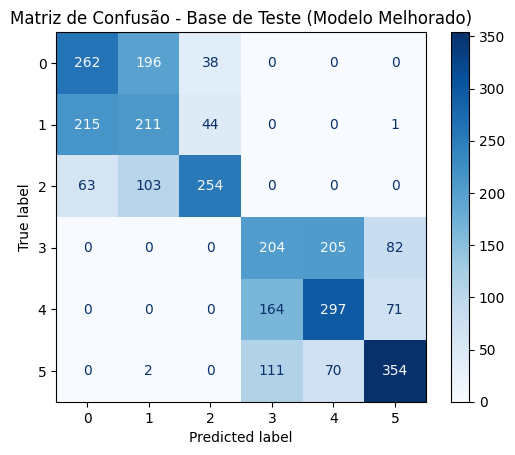

In [14]:
# Avaliação do novo modelo
y_pred_melhorado = modelo_melhorado.predict(X_test_sel)
acc_melhorado = accuracy_score(y_test, y_pred_melhorado)
print(f"Acurácia na base de teste com as 3 variáveis mais importantes: {acc_melhorado:.2%}")

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_melhorado)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - Base de Teste (Modelo Melhorado)")
plt.show()